<a href="https://colab.research.google.com/github/LucienShui/HelloMachineLearning/blob/master/Exercise_Flowers_with_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Packages

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Data Loading

In [0]:
URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), "flower_photos")

In [4]:
print(base_dir)
print(os.listdir(base_dir))

/root/.keras/datasets/flower_photos
['daisy', 'val', 'tulips', 'train', 'roses', 'dandelion', 'sunflowers', 'LICENSE.txt']


In [0]:
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [6]:
for class_name in classes:
    img_path = os.path.join(base_dir, class_name)
    images = glob.glob(img_path + '/*.jpg')
    print("{}: {} Images".format(class_name, len(images)))
    train, val = images[:round(len(images) * 0.8)], images[round(len(images) * 0.8):]

    for image in train:
        if not os.path.exists(os.path.join(base_dir, 'train', class_name)):
            os.makedirs(os.path.join(base_dir, 'train', class_name))
        try:
            shutil.move(image, os.path.join(base_dir, 'train', class_name))
        except Exception as e:
            pass
    
    for image in val:
        if not os.path.exists(os.path.join(base_dir, 'val', class_name)):
            os.makedirs(os.path.join(base_dir, 'val', class_name))
        try:
            shutil.move(image, os.path.join(base_dir, 'val', class_name))
        except Exception as e:
            pass
    
    os.system('rm -r ' + os.path.join(base_dir, class_name))

daisy: 633 Images
dandelion: 898 Images
roses: 641 Images
sunflowers: 699 Images
tulips: 799 Images


In [7]:
total_train = 0
for class_name in classes:
    cnt = len(os.listdir(os.path.join(base_dir, 'train', class_name)))
    print("train/{}: {}".format(class_name, cnt))
    total_train += cnt

print("Total Train Data: {}".format(total_train))

print("========")

total_val = 0
for class_name in classes:
    cnt = len(os.listdir(os.path.join(base_dir, 'val', class_name)))
    print("val/{}: {}".format(class_name, cnt))
    total_val += cnt

print("Total Validation Data: {}".format(total_val))

train/daisy: 506
train/dandelion: 718
train/roses: 513
train/sunflowers: 559
train/tulips: 639
Total Train Data: 2935
val/daisy: 127
val/dandelion: 180
val/roses: 128
val/sunflowers: 140
val/tulips: 160
Total Validation Data: 735


## Creating Data generator

In [0]:
BATCH_SIZE = 100
IMG_SHAPE = 128

In [0]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### Creating Training Data generator

In [10]:
image_generator_train = ImageDataGenerator(
    rescale=1./255, # 重新调整
    rotation_range=45,
    width_shift_range=0.2, # 宽度偏移范围
    height_shift_range=0.2,
    shear_range=0.2, # 剪切范围
    zoom_range=0.2, # 变焦范围
    horizontal_flip=True, # 水平翻转
    fill_mode='nearest'
)

train_data_gen = image_generator_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=os.path.join(base_dir, 'train') ,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE, IMG_SHAPE),
                                                           class_mode='sparse')

Found 2935 images belonging to 5 classes.


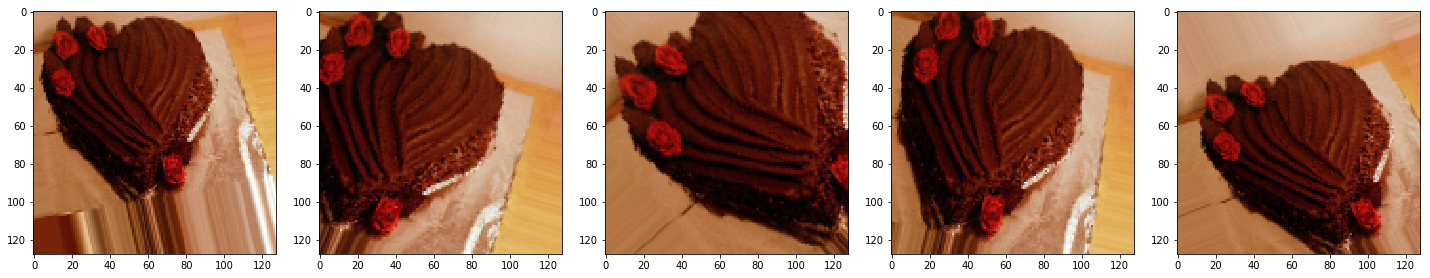

In [11]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Creating Validation Data generator

In [12]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=os.path.join(base_dir, 'val'),
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 735 images belonging to 5 classes.


## Create the CNN

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

W0811 13:37:40.528102 140348250138496 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Compile the Model

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       1

## Train the Model

In [16]:
EPOCHS = 100

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/100
30/30 [==============================] - 21s 704ms/step - loss: 1.3574 - acc: 0.3813 - val_loss: 1.1569 - val_acc: 0.4762
Epoch 2/100
30/30 [==============================] - 18s 610ms/step - loss: 1.1649 - acc: 0.5080 - val_loss: 1.0800 - val_acc: 0.5701
Epoch 3/100
30/30 [==============================] - 18s 611ms/step - loss: 1.0843 - acc: 0.5622 - val_loss: 0.9483 - val_acc: 0.6354
Epoch 4/100
30/30 [==============================] - 18s 598ms/step - loss: 0.9858 - acc: 0.6041 - val_loss: 0.8861 - val_acc: 0.6735
Epoch 5/100
30/30 [==============================] - 18s 597ms/step - loss: 0.8979 - acc: 0.6501 - val_loss: 0.8294 - val_acc: 0.6558
Epoch 6/100
30/30 [==============================] - 18s 603ms/step - loss: 0.9117 - acc: 0.6426 - val_loss: 0.8687 - val_acc: 0.6762
Epoch 7/100
30/30 [==============================] - 18s 604ms/step - loss: 0.8438 - acc: 0.6678 - val_loss: 0.7990 - val_acc: 0.6939
Epoch 8/100
30/30 [==============================] - 18s 599ms

## Visualizing results of the trainig

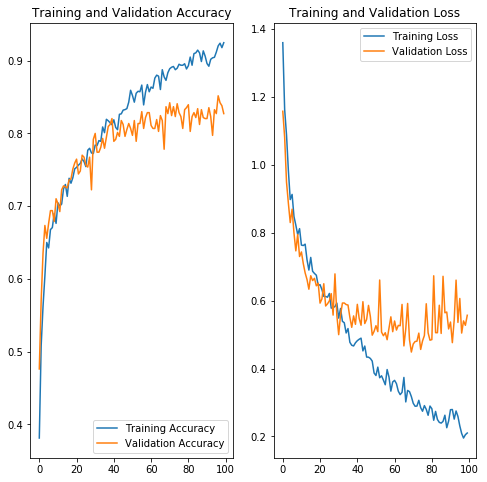

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()